# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Функции и библиотеки

In [78]:
!pip install lightgbm -U

In [167]:
!pip install catboost

In [169]:
import pandas as pd

import numpy as np

from sklearn.preprocessing import OrdinalEncoder 

from sklearn.metrics import mean_squared_error

from sklearn.preprocessing import StandardScaler 

import time

from sklearn.ensemble import RandomForestRegressor

import lightgbm as lgb

from catboost import CatBoostRegressor

from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression

from sklearn.model_selection import cross_val_score

from sklearn.metrics import make_scorer 

from sklearn.dummy import DummyRegressor

import warnings
warnings.filterwarnings('ignore')

## Обзор данных

**Признаки**

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- NotRepaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя

**Целевой признак**

- Price — цена (евро)

In [80]:
try:
    df = pd.read_csv ('D:/Data for projects/autos.csv')

except: 
    df = pd.read_csv ('/datasets/autos.csv')

In [81]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
DateCrawled          354369 non-null object
Price                354369 non-null int64
VehicleType          316879 non-null object
RegistrationYear     354369 non-null int64
Gearbox              334536 non-null object
Power                354369 non-null int64
Model                334664 non-null object
Kilometer            354369 non-null int64
RegistrationMonth    354369 non-null int64
FuelType             321474 non-null object
Brand                354369 non-null object
NotRepaired          283215 non-null object
DateCreated          354369 non-null object
NumberOfPictures     354369 non-null int64
PostalCode           354369 non-null int64
LastSeen             354369 non-null object
dtypes: int64(7), object(9)
memory usage: 43.3+ MB


In [82]:
df.nunique()

DateCrawled          271174
Price                  3731
VehicleType               8
RegistrationYear        151
Gearbox                   2
Power                   712
Model                   250
Kilometer                13
RegistrationMonth        13
FuelType                  7
Brand                    40
NotRepaired               2
DateCreated             109
NumberOfPictures          1
PostalCode             8143
LastSeen             179150
dtype: int64

проведем обзор уникальных значений в столбце RegistrationYear (год регистрации автомобиля)

In [83]:
df['RegistrationYear'].value_counts().sort_index()

1000    37
1001     1
1039     1
1111     3
1200     1
        ..
9000     3
9229     1
9450     1
9996     1
9999    26
Name: RegistrationYear, Length: 151, dtype: int64

проведем обзор уникальных значений месяцев регистрации автомобиля

In [84]:
df['RegistrationMonth'].value_counts().sort_index()

0     37352
1     23219
2     21267
3     34373
4     29270
5     29153
6     31508
7     27213
8     22627
9     23813
10    26099
11    24186
12    24289
Name: RegistrationMonth, dtype: int64

проведем обзор уникальных значений мощностей автомобилей

In [85]:
df['Power'].value_counts().sort_index()

0        40225
1           34
2           10
3            9
4           30
         ...  
17932        1
19208        1
19211        1
19312        1
20000        1
Name: Power, Length: 712, dtype: int64

проведем обзор дат создания анкет

In [86]:
df['DateCreated'].value_counts().sort_index()

2014-03-10 00:00:00        1
2015-03-20 00:00:00        1
2015-06-18 00:00:00        1
2015-08-07 00:00:00        1
2015-08-10 00:00:00        1
                       ...  
2016-04-03 00:00:00    13719
2016-04-04 00:00:00    13317
2016-04-05 00:00:00     4104
2016-04-06 00:00:00     1105
2016-04-07 00:00:00      549
Name: DateCreated, Length: 109, dtype: int64

In [87]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [88]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<div style="border:solid blue 2px; padding: 20px">

**По результатам обзора данных выявлено**:
    
    - не соответствие наименований признаков общепринятым
    - наличие пропусков в данных (столбцы VehicleType, Gearbox, Model, FuelType, NotRepaired)
    - в столбцах DateCrawled, LastSeen тип данных object а не datetime
    - в столбцах RegistrationYear, RegistrationMonth, Power имеются не реалистичные значения параметров
    - наличие параметров, характеризующих объявление/его привлекательность для покупателя, а не характеристики объекта продажи (DateCrawled, DateCreated, NumberOfPictures, LastSeen)
    

## Предобработка данных

### обработка наименования параметров

In [89]:
df = df.rename(columns={'DateCrawled': 'date_crawled', 
                        'Price': 'price', 
                        'VehicleType':'vehicle_type',
                        'RegistrationYear': 'registration_year',
                        'Gearbox':'gearbox',
                        'Power':'power',
                        'Model':'model',
                        'Kilometer':'kilometer',
                        'RegistrationMonth':'registration_month',
                        'FuelType':'fuel_type',
                        'Brand':'brand',
                        'NotRepaired':'not_repaired',
                        'DateCreated':'date_created',
                        'NumberOfPictures':'number_of_pictures',
                        'PostalCode':'postal_code',
                        'LastSeen':'last_seen'
                       })
df.columns

Index(['date_crawled', 'price', 'vehicle_type', 'registration_year', 'gearbox',
       'power', 'model', 'kilometer', 'registration_month', 'fuel_type',
       'brand', 'not_repaired', 'date_created', 'number_of_pictures',
       'postal_code', 'last_seen'],
      dtype='object')

### очистка данных 

В ходе обзора данных выявлено наличие признаков относящихся не к характеристикам автомобиля, определяющим его стоимость, а к качеству подготовки объявлений, столбцы DateCrawled, DateCreated, NumberOfPictures, LastSeen

**признаки в столбце postal_code могли бы использоваться для обучения если с помощью них обогатить исходные данные информацией о регионах продажи, однако в условях кейса они так же не отражают стоимостные характеристики автомобилей**

устраним избыточные не значащие данные

In [90]:
df = df.drop(['date_crawled','date_created', 'number_of_pictures', 'last_seen', 'postal_code'],axis=1) 

### обработка не качественных данных

#### registration_year

количество авто для которых registration_year лежит в диапазоне (1900,2017) 

In [91]:
_ = df.query('(registration_year > 1900) & (registration_year < 2017)')['registration_year'].value_counts().sum()
_

339773

% не качественных данных

In [92]:
round((len(df['registration_year']) - _)*100/len(df['registration_year']),2)

4.12

% данных не существенен, исключим не качественные данные

In [93]:
index= df.query('(registration_year > 1900) & (registration_year < 2017)').index

df = df.loc[index]

#### registration_month

количество авто для которых registration_month не равно 0

In [94]:
_ = df.query('registration_month != 0')['registration_month'].value_counts().sum()
_

306157

% не качественных данных

In [95]:
round((len(df['registration_month']) - _)*100/len(df['registration_month']),2)

9.89

% данных более существенен, однако оставшихся данных достаточно для обучения моделей, по этому исключим не качественные данные

In [96]:
index= df.query('registration_month != 0').index

df = df.loc[index]

#### power

In [97]:
df['power'].value_counts().sort_index()

0        22658
1           25
2            8
3            8
4           28
         ...  
17700        1
17932        1
19208        1
19312        1
20000        1
Name: power, Length: 665, dtype: int64

Согласно книге рекордов Гиннеса минимальная зафиксированная мощность авто = 4 л.с., максимальная мощность при этом может составлять 1600 л.с.

количество авто для которых power лежит в диапазоне (4,1600)

In [98]:
_ = df.query('(power > 4) & (power < 1601)')['power'].value_counts().sum()
_

283287

% не качественных данных

In [99]:
round((len(df['power']) - _)*100/len(df['power']),2)

7.47

% данных существенен, однако оставшихся данных достаточно для обучения моделей, по этому исключим не качественные данные

In [100]:
index= df.query('(power > 4) & (power < 1601)').index

df = df.loc[index]

### обработка пропусков

#### model

оценим количество данных с пропусками в признаке model (**обученая без этих признаков модель будет предсказывать стоимость типа транспортного средства и марки, а не стоимость конкретного авто**)

In [101]:
df['model'].isna().sum()

9504

% пропусков

In [102]:
round(df['model'].isna().sum()*100/len(df['model']),2)

3.35

% пропусков не существенен, исключим их

In [103]:
df = df.dropna(axis=0,subset=['model'])

#### vehicle_type,  gearbox, fuel_type, not_repaired

признаки vehicle_type, gearbox, fuel_type, not_repaired являются категориальными их возможно как исключить так и заполнить признаками "not defined", поскольку после исключения данных достаточно для обучения исключим пропуски

In [104]:
df = df.dropna(axis=0,subset=['vehicle_type', 'gearbox', 'fuel_type', 'not_repaired'])

In [105]:
df = df.reset_index(drop=True)

### кодирование признаков

In [106]:
encoder = OrdinalEncoder() 

columns_categorial = ['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'not_repaired']
df_cod = df.copy()

encoder.fit(df[columns_categorial]) 
df_cod[columns_categorial] = pd.DataFrame(encoder.transform(df_cod[columns_categorial]), columns=columns_categorial) 

## Подбор моделей

Рассмотрим данные для определения наиболее подходящих моделей

Признаки можно разделить на несколько групп

- отражающие характеристики автомобиля
    - VehicleType — тип автомобильного кузова
    - Brand — марка автомобиля
    - Model — модель автомобиля
    - Power — мощность (л. с.)
    - FuelType — тип топлива
    - Gearbox — тип коробки передач
- отражающие состояние автомобиля
    - RegistrationYear — год регистрации автомобиля
    - RegistrationMonth — месяц регистрации автомобиля
    - Kilometer — пробег (км)
    - NotRepaired — была машина в ремонте или нет
- отражающие характеристики объявления/владельца и т.д.
    - DateCrawled — дата скачивания анкеты из базы
    - DateCreated — дата создания анкеты
    - NumberOfPictures — количество фотографий автомобиля
    - PostalCode — почтовый индекс владельца анкеты (пользователя)
    - LastSeen — дата последней активности пользователя

Последняя группа признаков исключена на этапе предобработки данных

Учитывая постановку задачи (модель предполагается использовать для оценки автомобилей) разница в данных признаках заключается в том, что первая группа признаков формирует дипазон стоимости, а вторая определяет конкретное значение стоимости из данного диапазона.

при этом "ухудшение" параметров соответствует снижению стоимости в рамках дипазона (**можно предположить что снижение монотонно**)



выберем для обучения следующие модели:

- GradientBoostingRegressor (по условиям кейса)
- LightGBM (по условиям кейса)
- RandomForestRegressor 
- LinearRegression (высокая скорость)

## Обучение моделей

### подготовка признаков

In [107]:
features = df.drop('price',axis=1) # признаки 
target = df['price'] # целевой признак

In [108]:
features_cod = df_cod.drop('price',axis=1) # признаки 
target_cod = df_cod['price'] # целевой признак

In [109]:
features, features_test, target, target_test = train_test_split(
    features, target, test_size=0.25, random_state=404) #выделение тестовой выборки

In [110]:
features_cod, features_cod_test, target_cod, target_cod_test = train_test_split(
    features_cod, target_cod, test_size=0.25, random_state=404) #выделение тестовой выборки

In [111]:
print (features.shape,
features_test.shape,
target.shape,
target_test.shape)

(172503, 10) (57501, 10) (172503,) (57501,)


In [112]:
print (features_cod.shape,
features_cod_test.shape,
target_cod.shape,
target_cod_test.shape)

(172503, 10) (57501, 10) (172503,) (57501,)


In [113]:
features[columns_categorial] = features[columns_categorial].astype("category")
features_test[columns_categorial] = features_test[columns_categorial].astype("category")

### обучение моделей

#### Catboost

In [185]:
%%time

time.clock()

model_catboost =  CatBoostRegressor(
                                random_state=4040,  
                                max_depth=15,
                                n_estimators=60
                                           ) 
model_catboost.fit(features_cod,target_cod, verbose=10) # обучение модели

scores_catboost = cross_val_score(model_catboost, features_cod, target_cod, cv=5) 

print(scores_catboost.mean()) # расчет качества модели

time_catboost = time.clock()

Learning rate set to 0.5
0:	learn: 3106.4619703	total: 623ms	remaining: 36.7s
10:	learn: 1625.7566604	total: 6.09s	remaining: 27.1s
20:	learn: 1516.7942166	total: 11.1s	remaining: 20.5s
30:	learn: 1430.2838128	total: 16.1s	remaining: 15s
40:	learn: 1368.0363283	total: 21.2s	remaining: 9.82s
50:	learn: 1324.1702139	total: 26s	remaining: 4.58s
59:	learn: 1292.4305633	total: 30.3s	remaining: 0us
Learning rate set to 0.5
0:	learn: 3059.2506956	total: 504ms	remaining: 29.7s
1:	learn: 2336.1935658	total: 1.01s	remaining: 29.2s
2:	learn: 2006.9218740	total: 1.51s	remaining: 28.7s
3:	learn: 1861.8339547	total: 1.99s	remaining: 27.8s
4:	learn: 1777.8051076	total: 2.52s	remaining: 27.7s
5:	learn: 1730.6048785	total: 3.01s	remaining: 27.1s
6:	learn: 1695.3737736	total: 3.63s	remaining: 27.5s
7:	learn: 1664.7515536	total: 4.27s	remaining: 27.8s
8:	learn: 1645.6611357	total: 4.87s	remaining: 27.6s
9:	learn: 1633.9565983	total: 5.38s	remaining: 26.9s
10:	learn: 1613.0135250	total: 5.98s	remaining: 2

25:	learn: 1454.5386671	total: 13s	remaining: 17s
26:	learn: 1441.6658881	total: 13.5s	remaining: 16.5s
27:	learn: 1438.0571918	total: 14s	remaining: 16s
28:	learn: 1424.9320403	total: 14.5s	remaining: 15.5s
29:	learn: 1415.3767521	total: 15s	remaining: 15s
30:	learn: 1410.4735226	total: 15.4s	remaining: 14.5s
31:	learn: 1401.9640686	total: 15.9s	remaining: 13.9s
32:	learn: 1396.4660737	total: 16.4s	remaining: 13.4s
33:	learn: 1385.8994003	total: 16.9s	remaining: 12.9s
34:	learn: 1376.9670036	total: 17.4s	remaining: 12.4s
35:	learn: 1373.1670722	total: 17.9s	remaining: 11.9s
36:	learn: 1366.7396414	total: 18.3s	remaining: 11.4s
37:	learn: 1361.9230775	total: 18.8s	remaining: 10.9s
38:	learn: 1352.2063849	total: 19.3s	remaining: 10.4s
39:	learn: 1348.3377099	total: 19.8s	remaining: 9.88s
40:	learn: 1341.1710569	total: 20.2s	remaining: 9.38s
41:	learn: 1336.3707304	total: 20.7s	remaining: 8.88s
42:	learn: 1332.9578986	total: 21.2s	remaining: 8.37s
43:	learn: 1324.7358363	total: 21.7s	rem

58:	learn: 1272.3033937	total: 28.5s	remaining: 483ms
59:	learn: 1266.1694852	total: 29s	remaining: 0us
0.8780174027083504
Wall time: 3min 3s


#### LightGBM


In [114]:
%%time

model_lgb = lgb.LGBMRegressor()

n_estimators = [int(x) for x in np.linspace(start = 5, stop = 60, num = 20)]

max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]

parameters = {'n_estimators': n_estimators,
               'max_depth': max_depth}

randm_src = RandomizedSearchCV(estimator=model_lgb, param_distributions = parameters,
                               cv = 5, n_iter = 10, n_jobs=-1)
randm_src.fit(features, target)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
print("\n The best score across ALL searched params:\n", randm_src.best_score_)
print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.1, max_depth=12,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=45, n_jobs=-1, num_leaves=31, objective=None,
              random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent='warn',
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

 The best score across ALL searched params:
 0.8683072788316586

 The best parameters across ALL searched params:
 {'n_estimators': 45, 'max_depth': 12}
Wall time: 15 s


In [115]:
%%time

time.clock()

model_lgb =  lgb.LGBMRegressor(
                                random_state=4040,
                                boosting_type='gbdt',   
                                max_depth=15,
                                n_estimators=60, 
                                n_jobs=-1
                                           ) 
model_lgb.fit(features,target) # обучение модели

scores_lgb = cross_val_score(model_lgb, features, target, cv=5) 

print(scores_lgb.mean()) # расчет качества модели

time_lgb = time.clock()

0.8726849868583392
Wall time: 4.88 s


#### RandomForestRegressor

In [116]:
%%time

model_forest = RandomForestRegressor()

n_estimators = [int(x) for x in np.linspace(start = 5, stop = 60, num = 20)]

max_depth = [int(x) for x in np.linspace(start = 1, stop = 15, num = 15)]

parameters = {'n_estimators': n_estimators,
               'max_depth': max_depth}

randm_src = RandomizedSearchCV(estimator=model_forest, param_distributions = parameters,
                               cv = 5, n_iter = 10, n_jobs=-1)
randm_src.fit(features_cod, target_cod)

print(" Results from Random Search " )
print("\n The best estimator across ALL searched params:\n", randm_src.best_estimator_)
print("\n The best score across ALL searched params:\n", randm_src.best_score_)
print("\n The best parameters across ALL searched params:\n", randm_src.best_params_)

 Results from Random Search 

 The best estimator across ALL searched params:
 RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=15,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=31,
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)

 The best score across ALL searched params:
 0.8735924648560234

 The best parameters across ALL searched params:
 {'n_estimators': 31, 'max_depth': 15}
Wall time: 3min 18s


In [117]:
%%time

time.clock()

model_forest =  RandomForestRegressor(
                                random_state=4040,
                                bootstrap=True, 
                                max_depth=15,
                                n_estimators=36
                                           ) 
model_forest.fit(features_cod,target_cod) # обучение модели

scores_forest = cross_val_score(model_forest, features_cod, target_cod, cv=5) 

print(scores_forest.mean()) # расчет качества модели

time_forest = time.clock()

0.8735434003776936
Wall time: 1min 10s


#### LinearRegression

In [118]:
%%time

time.clock()

model_lin_reg = LinearRegression() 
model_lin_reg.fit(features_cod, target_cod) 

scores_lin_reg = cross_val_score(model_lin_reg, features_cod,target_cod, cv=5) 

print(scores_lin_reg.mean()) # расчет качества модели

time_lin_reg = time.clock()

0.5928692645382385
Wall time: 467 ms


Поэкспериментируйте и сравните характеристики моделей: скорость работы, точность результата.

Обучите разные модели. Для каждой попробуйте различные гиперпараметры.

Поскольку модель градиентного бустинга может обучаться долго, измените у неё только два-три параметра.

## Анализ моделей

In [119]:
dummy_regr = DummyRegressor(strategy="mean")
dummy_regr.fit(features_cod, target_cod)

predict = dummy_regr.predict(features_cod_test)

scores_dummy = mean_squared_error(target_cod_test, predict)**0.5 
scores_dummy

4736.73526200597

In [186]:
mean_squared_error(target_cod_test, model_catboost.predict(features_cod_test))**0.5

1629.4854105854608

In [120]:
mean_squared_error(target_test, model_lgb.predict(features_test))**0.5

1696.3691615903792

In [121]:
mean_squared_error(target_cod_test, model_forest.predict(features_cod_test))**0.5

1668.4940163517556

In [122]:
mean_squared_error(target_cod_test, model_lin_reg.predict(features_cod_test))**0.5

2952.815483961168

In [181]:
time_catboost

12861.8216154

In [123]:
time_lgb

573.4908283

In [124]:
time_forest 

842.9263134

In [125]:
time_lin_reg

843.4146817

In [188]:
indicators = pd.DataFrame([(time_lgb, mean_squared_error(target_test, model_lgb.predict(features_test))**0.5),
                   (time_forest , mean_squared_error(target_cod_test, model_forest.predict(features_cod_test))**0.5),
                   (time_lin_reg, mean_squared_error(target_cod_test, model_lin_reg.predict(features_cod_test))**0.5),
                   (time_catboost, mean_squared_error(target_cod_test, model_catboost.predict(features_cod_test))**0.5)],
                  index=['lgb', 'forest', 'lin_reg', 'catboost'],
                  columns=('time', 'rmse'))

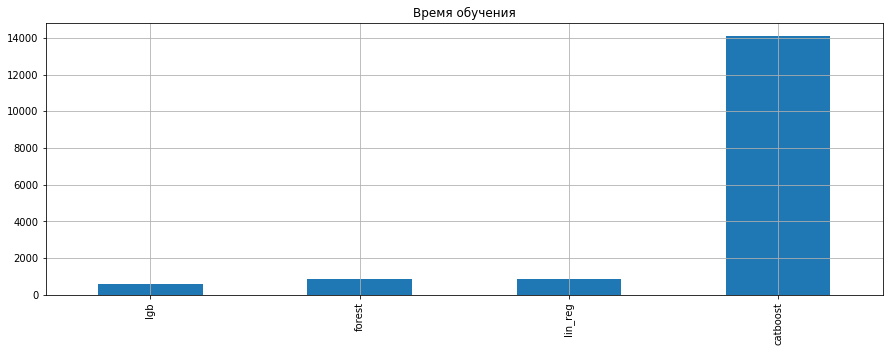

In [189]:
indicators['time'].plot(
                               kind='bar', 
                               figsize=(15,5), 
                               grid=True,
                               title='Время обучения')

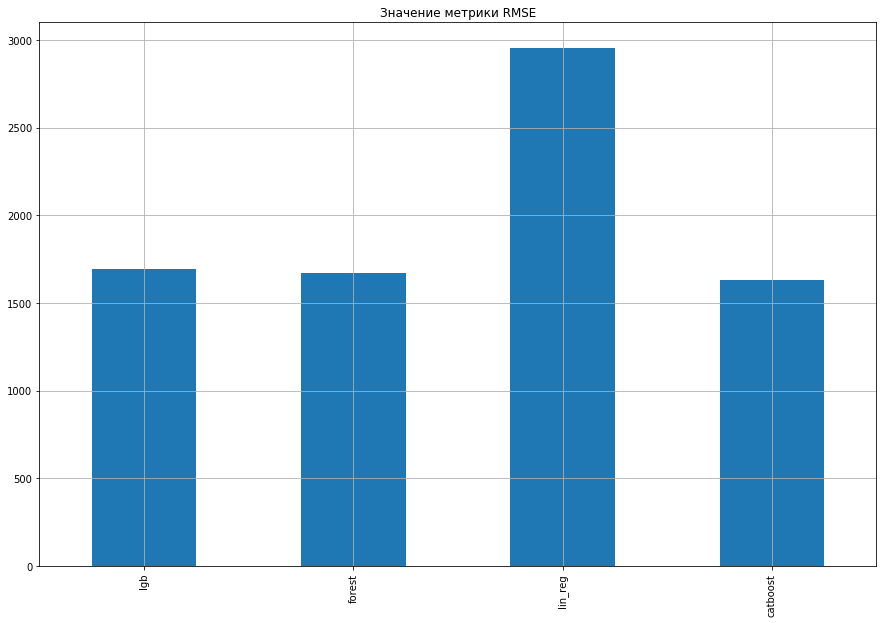

In [190]:
indicators['rmse'].plot(
                               kind='bar', 
                               figsize=(15,10), 
                               grid=True,
                               title='Значение метрики RMSE')

<div style="border:solid blue 2px; padding: 20px">

модель случайный лес показала сопоставимую с LightGBM точность, при больших временных затратах
лучшие показатели метрики RMSE показала catboost, как и наибольшее время исполнения кода
все модели кроме lin_reg соответствуют требованю по максмальному значнию метрики RMSE (2500)

## Заключение

В рамках настоящего исследования проведено обучение моделей для прогнозирования стоимости авто с пробегом